In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import ggplot
import seaborn as sns
import random
import xgboost as xgb
from scipy.stats import gaussian_kde
%matplotlib inline


/Library/Python/2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Python/2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets

# Table of Contents

1. Exploring the Data
2. Building a DataFrame and Standard Algorithm
3. Feature engineering/Feature Selection
4. Tuning the algorithm
5. Conclusions

## Exploring the Data


### Univariant Analysis

So lets take a first glance at what we have here:
    
- 6 files, all related by the key 'id'. Seems like we have to break down these relations first in order to get a coherent dataframe

After quickly scrolling through the data in MS Excel, i decided to do the following:
In order to just process numeric data, i dropped the strings from all the csv files containing the description ('event_type ', 'log_feature ', 'resource_type') manually with the replace function.



| id,event_type  	|   	
|:-:	|
|62093, ~~event_type~~ 15   	|





In [2]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

severity_type = pd.read_csv("Telstra/severity_type.csv")
severity_type_order = severity_type[['id']].drop_duplicates()
severity_type_order['order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)

print severity_type_order.shape

(18552, 2)


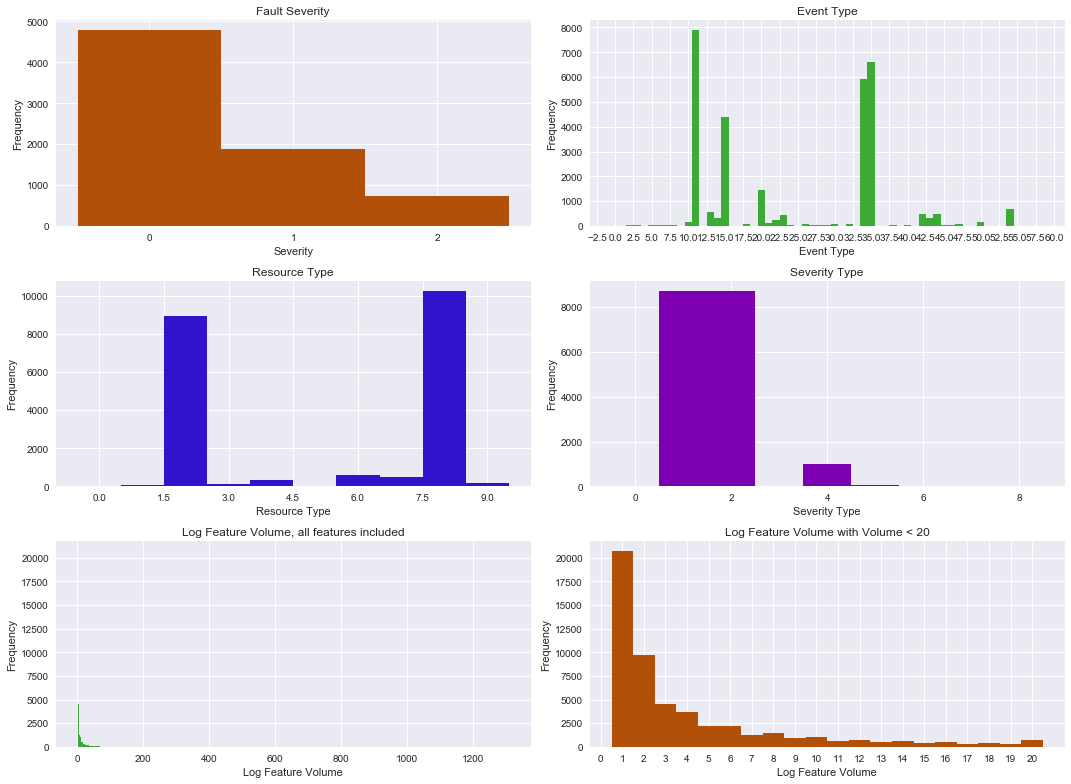

In [3]:
fig = plt.figure(figsize=(15,11))

###Fault Severity
ax1 = fig.add_subplot(321)
ax1.set_title('Fault Severity')
ax1.hist(train.fault_severity, bins=np.arange(4) - 0.5, color='#B25009')
ax1.set_xlabel('Severity')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(3))

### Event Type
ax2 = fig.add_subplot(322)
ax2.set_title('Event Type')
ax2.hist(events.event_type, bins=np.arange(60)-0.5,color='#3baa36')
ax2.set_xlabel('Event Type')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(60))
ax2.xaxis.set_major_locator(plt.MaxNLocator(30))


##Resource Type
ax3 = fig.add_subplot(323)
ax3.set_title('Resource Type')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Resource Type')
ax3.hist(resources.resource_type, bins=np.arange(11)-0.5, color = '#3014CC')
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))

#Severity Type
ax4 = fig.add_subplot(324)
ax4.set_title('Severity Type')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Severity Type')
ax4.hist(severity.severity_type, bins=np.arange(10)-0.5, color = '#7C00B2')

#Log Feature (All Datapoints)
ax5 = fig.add_subplot(325)
ax5.set_title('Log Feature Volume, all features included')
ax5.set_xlabel('Log Feature Volume')
ax5.set_ylabel('Frequency')
ax5.hist(log_feature.volume,bins=np.arange(log_feature.volume.min(), log_feature.volume.max()+1), align='left',color='#3baa36')

#Log Feature (All Datapoints)
ax6 = fig.add_subplot(326)
ax6.set_title('Log Feature Volume with Volume < 20')
ax6.set_xlabel('Log Feature Volume')
ax6.set_ylabel('Frequency')
ax6.set_xticks(range(21))
ax6.hist(log_feature.volume, bins=np.arange(log_feature.volume.min(), 22), align='left',color='#B25009')

#Display the figure
plt.tight_layout()
sns.plt.show()
fig.savefig('fig.png')

Our trainset shows the reports of 7381 incidents in total. Here is what i found out after graphing some of the data.


- As we can see, most of the interruptions are just a temporary network glitch ( *Fault Severity* = 0), but 1 and 2 do seem to cause problems quite frequently (around 35% of the time).

- The *event types* 11,35 and 34, 15 and 2 seem occur a lot together with a network incident ...


- The *resource types* 8 and 2 are used most. There is a significant gap between these two resources and the rest.

- The *severity type of warning messages* 1 and 2 seem to be the most frequent ones.

- The *log features* behave a little different here: We have a bunch of different features, which occur in a different Frequency (Volume). The two graphs above show just how often a given feature appears with an issue.
 Since the feature with the largest volume occurs 1350 times, the graph on the bottom left corner is highly skewed.


### Building a DataFrame and Standard Algorithm

Since the features are distributed over severall files and exist in a one-to-many fashion (one id can exist in N rows), its difficult to put them in. In order to do so, the data has to be merged together in one single dataframe. 

In [4]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

####### Saving labels
y = train.copy()
y = y.drop('location', axis=1)
y = y.drop('id', axis = 1)

###trainset with id & location
train = train.drop('fault_severity', axis = 1)

### Feature engineering: Add Severity type and severity type order
severity_type_order = severity[['id']].drop_duplicates()
severity_type_order['severity_order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)
train = pd.merge(train, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
train = pd.merge(train, severity_type_order, how='inner', on='id')

### Add Resources
resources = pd.get_dummies(resources, columns=['resource_type'])
resources = resources.groupby(['id']).sum()
resources = resources.reset_index()
train = pd.merge(train, resources, on='id',how='left')


### Add Event Type
events = pd.get_dummies(events, columns=['event_type'])
events = events.groupby(['id']).sum()
events = events.reset_index()
train = pd.merge(train, events, on='id',how='left')


## volume-hot encoding & Appending the log_features to the trainset, order is preserved
log_feature = pd.get_dummies(log_feature, columns=['log_feature'])
volume =  log_feature['volume'].as_matrix()
volume = np.transpose(np.atleast_2d(volume))
only_features = log_feature.iloc[:,2:].as_matrix()
only_features = volume*only_features
log_feature_vhot = pd.DataFrame(only_features, index=log_feature.index)
log_feature_vhot.columns = log_feature.iloc[:,2:].columns
log_feature_vhot['id'] = pd.Series(log_feature['id'])

# move the column to head of list using index, pop and insert
cols = list(log_feature_vhot)
cols.insert(0, cols.pop(cols.index('id')))
log_feature_vhot = log_feature_vhot.loc[:, cols]

#merge vhot into log_feature
log_feature = log_feature_vhot.groupby(['id']).sum()
log_feature = log_feature.reset_index()
#pd.options.display.max_columns = 15
#print log_feature.head(5)

train = pd.merge(train, log_feature, on='id',how='left')



In [5]:
#train.to_csv(path_or_buf='Telstra/understand_train.csv',index=False)

We now have a 7381x453 train dataset, since 'resources', 'events' and 'log_features' are all one-hot-encoded.
Now that we have created our dataframe with all our features, lets run the xgboost algorithm with its initial configuration for the first time on it & see what happens.


In [6]:
#### general settings l
from xgboost import XGBClassifier
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
#define classifier, to tune only once
def xgboost_classif():
    return xgb.XGBClassifier(max_depth=5)
def random_xgboost_classif():
    childweight = random.choice(range(1,3))
    eta = 0.01*float(random.choice(range(1,4)))
    bytree = 0.01*float(random.choice(range(1,25)))
    md = random.choice(range(3,8))
    SS = 0.01*float(random.choice(range(1,9)))
    LAMBDA = random.choice([0, 0.1, 0.5])
    parameters = {'min_child_weight': childweight,
                  'learning_rate': eta,
                  'colsample_bytree': bytree,
                  'max_depth': md,
                  'subsample': SS,
                  'reg_lambda': LAMBDA,
                  'objective': 'multi:softprob',
                  'silent': 1,
                  }
    return parameters


def parse_xgb_cv_result(result):
    result_df = []
    result_df = result
    return result_df

model_1 = xgboost_classif()
model_1.fit(X_train, y_train.values.ravel())
print(model_1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [7]:
## Show score
from sklearn.metrics import log_loss
y_pred = model_1.predict_proba(X_test)
print("Logloss: %.3f" % log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred))
#print("Logloss: %.3f" % log_loss(y_test,y_pred))

Logloss: 0.556


In [8]:
### Add Severity type,Resources, Event Type, log_features to test
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')

In [9]:
##Creating the final prediction data and submit it to kaggle.

test_pred = model_1.predict_proba(test)
final_pred = pd.DataFrame(test['id'])

result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

We scored a logloss of .5658% if we include ALL features (no feature engineering) and not further tune the parameters of our xgboost algorithm.

Our Kaggle score is 0.58768 with this very standard model, which would bring us to the 580th place on the leaderboard, if the competition was still on. Lets see if we can further improve our model.

## Feature Selection
Luckily, xgboost provides a way to have a look on which features are the most predictive ones. In order to do so, we test our prediction with different threshholds, and see which one will get us the highest accuracy.

In [10]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_2 = xgboost_classif()
model_2.fit(X_train, y_train.values.ravel())

# Fit model using each importance as a threshold
thresholds = -np.sort(-model_2.feature_importances_,)
thresholds = np.unique(thresholds)


In [11]:
i = 0
for thresh in thresholds:
    if i<10:
        i+=1
        # select features using threshold
        selection = SelectFromModel(model_2, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = xgboost_classif()
        selection_model.fit(select_X_train, y_train.values.ravel())
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)
        #print y_pred
        #print y_test['fault_severity'].as_matrix(columns=None)
        loss = log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred)
        print("Thresh=%.5f, n=%d, Log_loss: %.4f" % (thresh, select_X_train.shape[1], loss))

Thresh=0.00000, n=453, Log_loss: 0.5558
Thresh=0.00023, n=122, Log_loss: 0.5558
Thresh=0.00046, n=113, Log_loss: 0.5584
Thresh=0.00070, n=106, Log_loss: 0.5584
Thresh=0.00093, n=91, Log_loss: 0.5589
Thresh=0.00116, n=88, Log_loss: 0.5587
Thresh=0.00139, n=83, Log_loss: 0.5578
Thresh=0.00163, n=79, Log_loss: 0.5581
Thresh=0.00186, n=77, Log_loss: 0.5574
Thresh=0.00209, n=73, Log_loss: 0.5575


In [12]:
##prepare the testset again
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')


###rerun initial model, use up all the data for training
model_3 = xgboost_classif()
model_3.fit(train, y.values.ravel())

## select features using threshold
selection = SelectFromModel(model_3, threshold=0.000215, prefit=True)
select_X_train = selection.transform(train)
## train model
selection_model = xgboost_classif()
selection_model.fit(select_X_train, y.values.ravel())
select_X_test_final = selection.transform(test)
y_pred_final = selection_model.predict_proba(select_X_test_final)

#create final dataframe
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = y_pred_final)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)


Sadly, feature selection doesnt improve the log loss.

In [13]:
#Converting the new trainset (select_X_train) back to a pandas frame
select_X_train=pd.DataFrame(select_X_train)
labels = train.iloc[:, selection.get_support()]
select_train = pd.DataFrame(selection.transform(train), columns=labels.columns)
#select_train.to_csv(path_or_buf='Telstra/understand_select.csv',index=False)


## Parameter Tuning

In [14]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

#train = pd.read_csv('train_modified.csv')
train['fault_severity'] = y
target = 'fault_severity'
IDcol = 'id'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5):
    # thanks to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    if useTrainCV: 
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain,num_boost_round=alg.get_params()['n_estimators'], verbose_eval = True, nfold=10, feval=evalerror, seed=0)
        alg.set_params(n_estimators=cvresult.shape[0])
        dtrain_fs = np.transpose(np.atleast_2d(dtrain['fault_severity'].values))
      
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['fault_severity'],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])
    dtrain_pred = np.transpose(np.atleast_2d(dtrain_predictions))
    #Print model report:
    print "\nModel Report"
    print "Logloss : %.4g" % log_loss(dtrain_fs,dtrain_predprob)

def evalerror(xtrain, labels):
    return 'mlogloss', log_loss(labels.get_label(),xtrain)

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
#testing some different parameters
#n_estimators=1000,
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=488,  
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softprob',
 scale_pos_weight=1,
 )

modelfit(xgb1, train, predictors)


[0]	train-merror:0.250527+0.00302468	train-mlogloss:1.03392+0.00060224	test-merror:0.265854+0.0113336	test-mlogloss:1.03598+0.00162841
[1]	train-merror:0.248479+0.00190102	train-mlogloss:0.979168+0.00135407	test-merror:0.260434+0.00997229	test-mlogloss:0.983047+0.00247689
[2]	train-merror:0.247922+0.00210235	train-mlogloss:0.932838+0.00202245	test-merror:0.259621+0.00907371	test-mlogloss:0.938124+0.0029475
[3]	train-merror:0.246974+0.00266386	train-mlogloss:0.892092+0.00256837	test-merror:0.258943+0.0066507	test-mlogloss:0.899162+0.00417224
[4]	train-merror:0.245619+0.00256856	train-mlogloss:0.857263+0.00273571	test-merror:0.260569+0.0081538	test-mlogloss:0.866072+0.00404409
[5]	train-merror:0.244685+0.00262401	train-mlogloss:0.825571+0.00287364	test-merror:0.257588+0.00983589	test-mlogloss:0.836026+0.00549631
[6]	train-merror:0.244385+0.00259103	train-mlogloss:0.797795+0.0023131	test-merror:0.256775+0.0100356	test-mlogloss:0.809757+0.00670565
[7]	train-merror:0.243406+0.00220658	train

[61]	train-merror:0.208507+0.00238657	train-mlogloss:0.479129+0.00191967	test-merror:0.242412+0.0114571	test-mlogloss:0.540776+0.0117047
[62]	train-merror:0.207904+0.00217792	train-mlogloss:0.477794+0.00182466	test-merror:0.24187+0.0113896	test-mlogloss:0.539986+0.011607
[63]	train-merror:0.207483+0.00250717	train-mlogloss:0.476605+0.00181804	test-merror:0.241734+0.0110451	test-mlogloss:0.539271+0.0114725
[64]	train-merror:0.20682+0.00250664	train-mlogloss:0.475411+0.00181737	test-merror:0.241599+0.0118138	test-mlogloss:0.538549+0.0114144
[65]	train-merror:0.205811+0.00237777	train-mlogloss:0.474094+0.00182757	test-merror:0.241734+0.0117537	test-mlogloss:0.537824+0.0114313
[66]	train-merror:0.204712+0.00238547	train-mlogloss:0.472815+0.00174361	test-merror:0.242141+0.0124347	test-mlogloss:0.537228+0.0114575
[67]	train-merror:0.203975+0.00211087	train-mlogloss:0.471741+0.00169415	test-merror:0.241599+0.0128128	test-mlogloss:0.536789+0.0115543
[68]	train-merror:0.203478+0.00237697	train-

[121]	train-merror:0.172313+0.00248421	train-mlogloss:0.419221+0.00223745	test-merror:0.235501+0.011366	test-mlogloss:0.51725+0.0113432
[122]	train-merror:0.171876+0.00241207	train-mlogloss:0.418396+0.00210273	test-merror:0.235095+0.0107252	test-mlogloss:0.517063+0.011427
[123]	train-merror:0.1715+0.00245142	train-mlogloss:0.417578+0.00210828	test-merror:0.235095+0.0113248	test-mlogloss:0.516929+0.0114275
[124]	train-merror:0.171033+0.00226336	train-mlogloss:0.416678+0.00218408	test-merror:0.234282+0.0116162	test-mlogloss:0.516514+0.0114338
[125]	train-merror:0.170732+0.00204567	train-mlogloss:0.415899+0.00222158	test-merror:0.234282+0.0116636	test-mlogloss:0.516254+0.0114364
[126]	train-merror:0.17019+0.00202253	train-mlogloss:0.415038+0.00219105	test-merror:0.234417+0.0116249	test-mlogloss:0.516096+0.0116402
[127]	train-merror:0.169542+0.00192262	train-mlogloss:0.414234+0.00218013	test-merror:0.235095+0.0114859	test-mlogloss:0.516044+0.0118797
[128]	train-merror:0.169045+0.00188037	t

[181]	train-merror:0.145995+0.00200766	train-mlogloss:0.375812+0.00256713	test-merror:0.227913+0.0162805	test-mlogloss:0.507478+0.0126156
[182]	train-merror:0.145363+0.00220671	train-mlogloss:0.375176+0.00256104	test-merror:0.228455+0.0159777	test-mlogloss:0.507339+0.0125674
[183]	train-merror:0.144971+0.00216888	train-mlogloss:0.374409+0.00254913	test-merror:0.228862+0.0154311	test-mlogloss:0.507108+0.012733
[184]	train-merror:0.144535+0.00223896	train-mlogloss:0.373728+0.00259419	test-merror:0.228726+0.0155183	test-mlogloss:0.506958+0.0126243
[185]	train-merror:0.144128+0.00234413	train-mlogloss:0.372954+0.00252634	test-merror:0.228455+0.0149691	test-mlogloss:0.506792+0.0126611
[186]	train-merror:0.143541+0.00233936	train-mlogloss:0.372252+0.00246923	test-merror:0.228049+0.0149672	test-mlogloss:0.506586+0.0126802
[187]	train-merror:0.142999+0.00237844	train-mlogloss:0.371568+0.00242002	test-merror:0.228048+0.0143278	test-mlogloss:0.506536+0.0125236
[188]	train-merror:0.142593+0.00232

[241]	train-merror:0.12433+0.00333676	train-mlogloss:0.340266+0.00284757	test-merror:0.223848+0.0174455	test-mlogloss:0.501583+0.0128558
[242]	train-merror:0.123833+0.0031734	train-mlogloss:0.339667+0.00275041	test-merror:0.223848+0.0181673	test-mlogloss:0.501499+0.0129048
[243]	train-merror:0.123442+0.00311799	train-mlogloss:0.339104+0.00273828	test-merror:0.223442+0.0177548	test-mlogloss:0.501462+0.0128691
[244]	train-merror:0.12287+0.00320816	train-mlogloss:0.338556+0.00266016	test-merror:0.223035+0.0175127	test-mlogloss:0.501431+0.0129558
[245]	train-merror:0.122418+0.00326152	train-mlogloss:0.338071+0.00263561	test-merror:0.223171+0.0179154	test-mlogloss:0.501449+0.0129164
[246]	train-merror:0.122192+0.00341268	train-mlogloss:0.337655+0.00266581	test-merror:0.223171+0.0180583	test-mlogloss:0.501377+0.0129544
[247]	train-merror:0.12177+0.00348474	train-mlogloss:0.337077+0.00260225	test-merror:0.223171+0.0178949	test-mlogloss:0.501201+0.0130242
[248]	train-merror:0.121394+0.00333003

[301]	train-merror:0.105224+0.00272376	train-mlogloss:0.31011+0.00254885	test-merror:0.222629+0.0176989	test-mlogloss:0.500106+0.0138984
[302]	train-merror:0.105028+0.00264838	train-mlogloss:0.309623+0.00258567	test-merror:0.223035+0.017099	test-mlogloss:0.499956+0.0137006
[303]	train-merror:0.104411+0.00246313	train-mlogloss:0.309106+0.00249762	test-merror:0.222358+0.0175677	test-mlogloss:0.499942+0.0136237
[304]	train-merror:0.10405+0.00249899	train-mlogloss:0.308643+0.00245273	test-merror:0.221545+0.0172598	test-mlogloss:0.499954+0.0135998
[305]	train-merror:0.103839+0.00260945	train-mlogloss:0.308263+0.00246282	test-merror:0.22168+0.0176068	test-mlogloss:0.500019+0.0136724
[306]	train-merror:0.103598+0.00243928	train-mlogloss:0.307872+0.00247035	test-merror:0.222222+0.0178018	test-mlogloss:0.499992+0.0137733
[307]	train-merror:0.103403+0.00247551	train-mlogloss:0.307497+0.00249738	test-merror:0.221951+0.0176443	test-mlogloss:0.499995+0.0138054
[308]	train-merror:0.103192+0.00261299

[361]	train-merror:0.090259+0.00290477	train-mlogloss:0.285157+0.00252745	test-merror:0.219377+0.0157955	test-mlogloss:0.500196+0.0147497
[362]	train-merror:0.0900784+0.00271344	train-mlogloss:0.28479+0.00250484	test-merror:0.219241+0.0158112	test-mlogloss:0.500235+0.0147935
[363]	train-merror:0.0898976+0.00274699	train-mlogloss:0.284438+0.00248328	test-merror:0.218563+0.0158604	test-mlogloss:0.500239+0.0147523
[364]	train-merror:0.0896717+0.00279897	train-mlogloss:0.284004+0.00247155	test-merror:0.219377+0.0166665	test-mlogloss:0.500239+0.0146666
[365]	train-merror:0.0894309+0.0025122	train-mlogloss:0.283583+0.00246673	test-merror:0.219106+0.01664	test-mlogloss:0.500339+0.0146362
[366]	train-merror:0.0893707+0.00264066	train-mlogloss:0.283224+0.00241836	test-merror:0.218699+0.0170342	test-mlogloss:0.500347+0.0145219
[367]	train-merror:0.0891901+0.00259034	train-mlogloss:0.282787+0.00240641	test-merror:0.218428+0.0172442	test-mlogloss:0.50039+0.0144619
[368]	train-merror:0.0890546+0.00

[421]	train-merror:0.0772509+0.00325386	train-mlogloss:0.262979+0.0023523	test-merror:0.218563+0.0140431	test-mlogloss:0.500801+0.0146148
[422]	train-merror:0.0771453+0.00328905	train-mlogloss:0.262684+0.00233439	test-merror:0.218834+0.0142919	test-mlogloss:0.500799+0.0146908
[423]	train-merror:0.0768744+0.00333629	train-mlogloss:0.262313+0.00234481	test-merror:0.219106+0.0143406	test-mlogloss:0.500786+0.0146689
[424]	train-merror:0.0767387+0.00332528	train-mlogloss:0.261961+0.00235894	test-merror:0.219241+0.0146541	test-mlogloss:0.50081+0.014702
[425]	train-merror:0.076498+0.00331653	train-mlogloss:0.261629+0.0023874	test-merror:0.219647+0.0143329	test-mlogloss:0.500803+0.0146769
[426]	train-merror:0.0763476+0.00349511	train-mlogloss:0.261271+0.00239989	test-merror:0.219241+0.0138024	test-mlogloss:0.500907+0.0146683
[427]	train-merror:0.0760614+0.00352611	train-mlogloss:0.260993+0.00241957	test-merror:0.219106+0.0141732	test-mlogloss:0.500873+0.0147503
[428]	train-merror:0.0758507+0.0

[481]	train-merror:0.0669677+0.0030773	train-mlogloss:0.243107+0.00248242	test-merror:0.21897+0.013154	test-mlogloss:0.502243+0.0147283
[482]	train-merror:0.0667118+0.00310061	train-mlogloss:0.242757+0.00246542	test-merror:0.21897+0.013112	test-mlogloss:0.502253+0.0147199
[483]	train-merror:0.0665764+0.00318305	train-mlogloss:0.242453+0.00245837	test-merror:0.218834+0.0126857	test-mlogloss:0.502376+0.0146848
[484]	train-merror:0.0663204+0.00298634	train-mlogloss:0.24209+0.00239672	test-merror:0.21897+0.0125979	test-mlogloss:0.502392+0.0147959
[485]	train-merror:0.0660195+0.00289458	train-mlogloss:0.241724+0.00242377	test-merror:0.218563+0.0134145	test-mlogloss:0.50251+0.0148538
[486]	train-merror:0.0658385+0.00301941	train-mlogloss:0.241392+0.00240468	test-merror:0.218293+0.0132548	test-mlogloss:0.502394+0.014826
[487]	train-merror:0.0657634+0.00294159	train-mlogloss:0.241012+0.00241116	test-merror:0.218293+0.0134746	test-mlogloss:0.502419+0.0148261

Model Report
Logloss : 0.2512


In [17]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=488, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', scale_pos_weight=1),verbose = 10, 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=3 .................................
[CV] max_depth=3, min_child_weight=3 .................................


KeyboardInterrupt: 

Increasing the number of estimators improved the model significantly!

In [18]:
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')

test_pred = xgb1.predict_proba(test)
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)
#scored 0.50050 on kaggle
#TODO: guess i could have spent more time on feature engineering. Submitted the project to udacity and will now put it on hold